In [1]:
%run ../../base-notebook.ipynb

TensorFlow version: 2.12.0
TensorFlow-Text version: 2.12.0
Python version 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]


In [2]:
import so_ml_tools as soml

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras import backend as K
from keras import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, RandomFlip, RandomZoom, RandomHeight, RandomWidth, RandomRotation, Input, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from keras.utils import image_dataset_from_directory

## Download our dataset, extract and list contents

In [3]:
soml.util.io.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip',
                   './10_food_classes_10_percent.zip')
soml.util.io.extract_zip(filepath='10_food_classes_10_percent.zip')
soml.util.io.list_dir_summary('./10_food_classes_10_percent')

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip completed.


In [6]:
train_dir = './data//10_food_classes_10_percent/train'
test_dir = './data/10_food_classes_10_percent/test'

## Load the data

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical',
                                                     batch_size=BATCH_SIZE
                                                     )

test_data_10_percent = image_dataset_from_directory(directory=test_dir,
                                                    image_size=IMG_SIZE,
                                                    label_mode='categorical',
                                                    batch_size=32)

Found 750 files belonging to 10 classes.
Metal device set to: Apple M1 Max
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Display class names

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Create functional model based on the EfficientNet B0 Model.

In [10]:
# 1. Create a base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If your using ResMet50V2 you will need to normalize inputs (you don't have to for efficientnet,
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the models
x = base_model(inputs)
print(f"Shape after passing inputs through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
print(f"Shape after passing through GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

tensorboard_callback = soml.tf.model.callback.tensorboard_callback(experiment_name="model_0", dir_name="./logs")


# 10. Fit the model
model_0_history = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25 * len(test_data_10_percent)),
                              callbacks=[tensorboard_callback])

K.clear_session()

Shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after passing through GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: ./logs/model_0/20230831-223820
Epoch 1/5


2023-08-31 22:38:23.501881: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 10s 195ms/step - loss: 1.8706 - accuracy: 0.4253 - val_loss: 1.3147 - val_accuracy: 0.7401
Epoch 2/5
24/24 [==============================] - 2s 102ms/step - loss: 1.0907 - accuracy: 0.7707 - val_loss: 0.8601 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 2s 100ms/step - loss: 0.7836 - accuracy: 0.8213 - val_loss: 0.7276 - val_accuracy: 0.8520
Epoch 4/5
24/24 [==============================] - 2s 97ms/step - loss: 0.6525 - accuracy: 0.8560 - val_loss: 0.6156 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 2s 96ms/step - loss: 0.5478 - accuracy: 0.8787 - val_loss: 0.5758 - val_accuracy: 0.8668


## Plot model history and accuracy

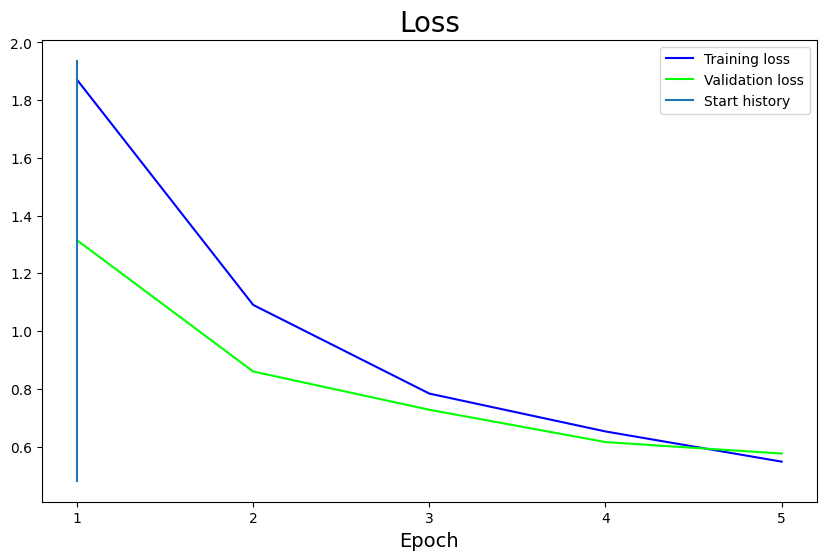

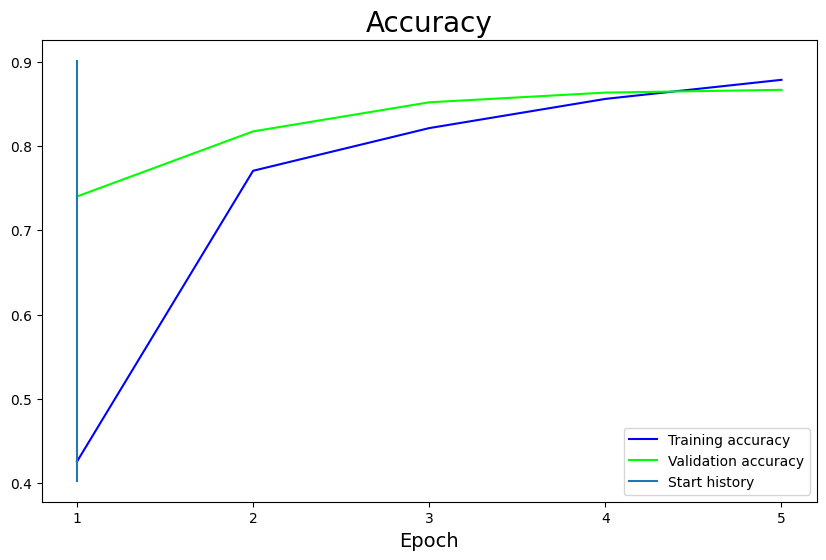

In [11]:
soml.tf.model.plot.plot_history(model_0_history)

In [12]:
model_0_evaluation = model_0.evaluate(test_data_10_percent)
model_0_evaluation

79/79 [==============================] - 6s 66ms/step - loss: 0.5569 - accuracy: 0.8640


[0.556882381439209, 0.8640000224113464]

## Display model details

In [13]:
soml.tf.model.layer.list_model(model_0, recursive=True, include_trainable=True, include_non_trainable=True)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)]   
1     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
2     | rescaling                 (Rescaling             ) | float32 | float32 | False     | (None, None, None, 3)   
3     | normalization             (Normalization         ) | float32 | float32 | False     | (None, None, None, 3)   
4     | rescaling_1               (Rescaling             ) | float32 | float32 | False     | (None, None, None, 3)   
5     | stem_conv_pad             (ZeroPadding2D         ) | float32 | float32 | False     | (None, None, None, 3)   
6     | stem_conv                 (Conv2D                ) | float32 | float32 | False     | (None, None, None, 32)  
7     | stem_bn                   (BatchNormalization    ) | float32

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the GlobalAveragePooling2D layer.

We have a tensor after our model goes through `base_model` of shape (7, 7, 1288).

But then when it passes through GlobalAveragePooling2D it turns into (None, 1280)

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it thourgh GlobalAveragePooling2D

In [15]:
# Define the input shape
INPUT_SHAPE = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(INPUT_SHAPE)

print(f"Random input tensor:\n{input_tensor}")

Random input tensor:
[[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]]


In [16]:
# Pass the random tenstor through a GlobalAveragePooling2D
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D().call(input_tensor)

print(
    f"2D Global average pooled random tensor:\n{global_average_pooled_tensor}\n\nShape:\n{global_average_pooled_tensor.shape}")

2D Global average pooled random tensor:
[[-0.09368647 -0.45840445 -0.28855982]]

Shape:
(1, 3)


In [17]:
# Let's replicate the global average pool 2D layer.
tf.reduce_mean(input_tensor, axis=(1, 2))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

In [18]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D().call(input_tensor)
print(
    f"2D Global max pooled random tensor:\n{global_max_pooled_tensor}\n\nShape:\n{global_average_pooled_tensor.shape}")


2D Global max pooled random tensor:
[[0.9058465 1.1603122 1.6994324]]

Shape:
(1, 3)


## Running a series of transfer learning experiments.

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... How about we setup a bunch of experiments to find out.

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. 'model_2' - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. 'model_3' - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. 'model_4' - use fine-tuning transfer learning on 100% of the training data with data augmentation

Note: throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation matrics.

In [19]:
# Download the 1% dataset
soml.util.io.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip',
                   './10_food_classes_1_percent.zip')
soml.util.io.extract_zip(filepath='10_food_classes_1_percent.zip')
soml.util.io.list_dir_summary('./10_food_classes_1_percent')

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip completed.


In [22]:
train_dir = './data/10_food_classes_1_percent/train'
test_dir = './data/10_food_classes_1_percent/test'

In [23]:
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           batch_size=BATCH_SIZE,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical')

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          batch_size=BATCH_SIZE,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode='categorical')



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation:

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewere.

In [24]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms, etc..
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(factor=.2),
    RandomZoom(.2),
    RandomHeight(.2),
    RandomWidth(.2),
    # Rescaling(1./255) # Keep for models like ResNet50V2, but EfficientNetB0 does not need this.
], name="data-augmentation")

### Visualize our data augmentation layer

./data/10_food_classes_1_percent/train/sushi
  [ 9 20 24]
  [ 8 19 23]
  ...
  [25 17  6]
  [26 16  6]
  [24 14  4]]

 [[10 21 25]
  [ 8 19 23]
  [ 7 18 22]
  ...
  [22 14  3]
  [23 13  3]
  [21 11  1]]

 [[ 9 20 24]
  [ 7 18 22]
  [ 5 16 18]
  ...
  [23 15  4]
  [24 14  4]
  [21 11  1]]

 ...

 [[13  5  3]
  [12  4  2]
  [ 8  3  0]
  ...
  [16 11  5]
  [16 12  3]
  [14 10  1]]

 [[10  4  6]
  [ 9  3  5]
  [ 6  2  1]
  ...
  [16 11  5]
  [18 11  3]
  [16  9  1]]

 [[ 9  3  5]
  [ 8  2  4]
  [ 6  2  1]
  ...
  [16 11  5]
  [18 11  3]
  [16  9  1]]]. Consider rewriting this model with the Functional API.


(-0.5, 573.5, 361.5, -0.5)

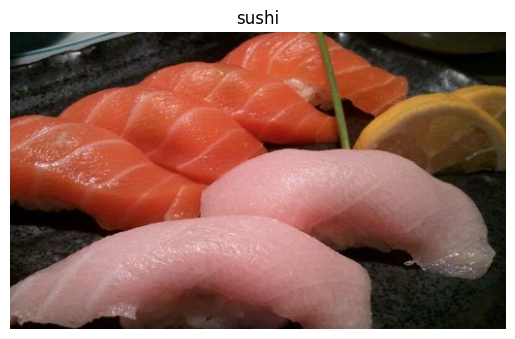

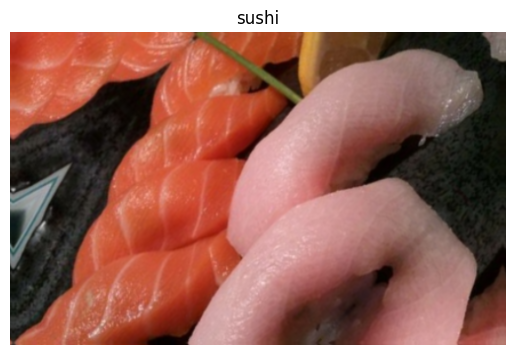

In [26]:
# View a random image and compare it to its augmented version
import os
import random

target_class = random.choice(train_data_1_percent.class_names)

target_dir = "./data/10_food_classes_1_percent/train/" + target_class
print(target_dir)

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.title(target_class)
plt.imshow(img / 255.)
plt.axis(False)

augmented_img = data_augmentation.call(img, training=True)
plt.figure()
plt.title(target_class)
plt.imshow(augmented_img / 255.)
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [27]:
# Setup input shape and base model
INPUT_SHAPE = (224, 224, 3)

In [28]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = Input(shape=INPUT_SHAPE, name="Input Layer")

# Add in data augmentation Sequential
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put a dense layer on as the output layer
outputs = Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs / outputs.
model_1 = Model(inputs, outputs)

# Compile the model
model_1.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

tensorboard_callback = soml.tf.model.callback.tensorboard_callback(experiment_name="model_1", dir_name="./logs")

model_1_history = model_1.fit(train_data_1_percent, steps_per_epoch=len(train_data_1_percent),
                              epochs=5,
                              validation_data=test_data_1_percent,
                              validation_steps=int(0.25 * len(test_data_1_percent)),
                              callbacks=[tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_1/20230831-223930
Epoch 1/5
3/3 [==============================] - 12s 3s/step - loss: 2.4222 - accuracy: 0.0714 - val_loss: 2.2499 - val_accuracy: 0.1546
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2091 - accuracy: 0.1714 - val_loss: 2.1273 - val_accuracy: 0.2171
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 2.0209 - accuracy: 0.3286 - val_loss: 2.0185 - val_accuracy: 0.2845
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7971 - accuracy: 0.4714 - val_loss: 1.8944 - val_accuracy: 0.3586
Epoch 5/5
3/3 [==============================] - 6s 2s/step - loss: 1.6436 - accuracy: 0.6571 - val_loss: 1.7931 - val_accuracy: 0.4375


In [29]:
# Check model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data-augmentation (Sequenti  multiple                 0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [30]:
# Evaluate on full data set
model_1_evaluation = model_1.evaluate(test_data_1_percent)
model_1_evaluation

79/79 [==============================] - 7s 70ms/step - loss: 1.8063 - accuracy: 0.4468


[1.8062896728515625, 0.44679999351501465]

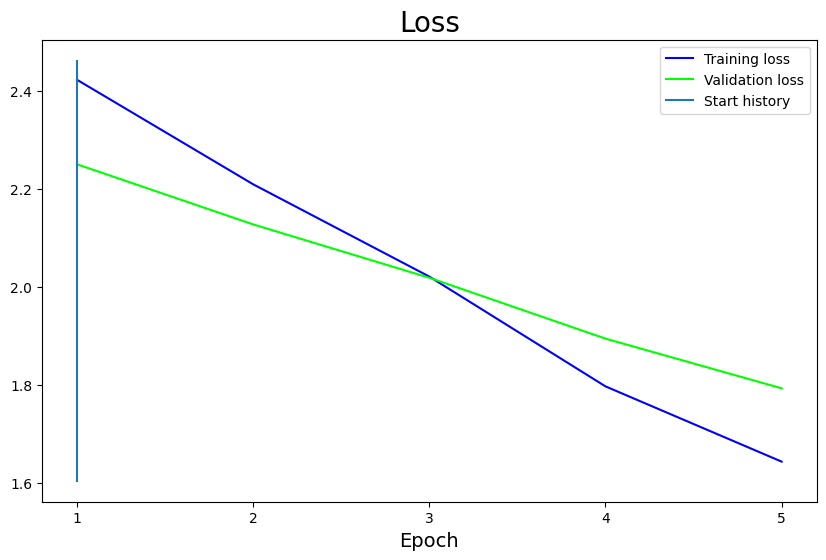

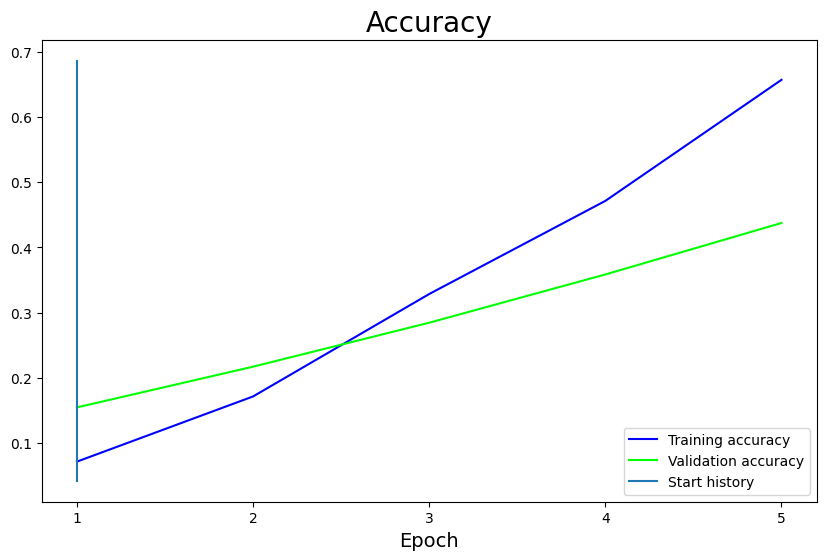

In [31]:
soml.tf.model.plot.plot_history(model_1_history)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [32]:
# Get 10% of data
# mlio.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip', './10_food_classes_10_percent.zip')
# mlio.extract_zip(filepath='10_food_classes_10_percent.zip')
# mlio.list_dir_summary('./10_food_classes_10_percent')

In [35]:
train_dir = './data/10_food_classes_10_percent/train'
test_dir = './data/10_food_classes_10_percent/test'

In [36]:
# Set data inputs
IMG_SIZE = (224, 224)

train_data_10_percent = image_dataset_from_directory(directory=train_dir,
                                                     label_mode='categorical',
                                                     image_size=IMG_SIZE,
                                                     batch_size=32)

test_data_10_percent = image_dataset_from_directory(directory=test_dir,
                                                    label_mode='categorical',
                                                    image_size=IMG_SIZE,
                                                    batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [37]:
# Create model 2 with data augmentation

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomHeight(.2),
    RandomWidth(.2),
    RandomRotation(.2),
    RandomZoom(.2),
    # Rescaling(1/.255) # if you're using a model such as ResNet50V2, you'll need to rescale the data
], name="data_augemtation")

In [38]:
INPUT_SHAPE = IMG_SIZE + (3,)

# Create a frozen base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs including the layers in between.
inputs = Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(inputs)  # Augmentation doesn't occure on test data
x = base_model(x,
               training=False)  # Pass augmented images to base model but keep the base model in inference mode, this also insures batchnorm layers don't get updated
x = GlobalAveragePooling2D(name='global_average_pooling_2d')(x)

outputs = Dense(10, activation="softmax", name="output_layer")(x)

model_2 = Model(inputs, outputs)

model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [39]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augemtation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### Creating a ModelCheckpoint callback and fit model 2

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is usefull so we can come back and start where we left off.

In [40]:
initial_epochs = 5

checkpoint_callback = soml.tf.model.callback.model_checkpoint_callback(experiment_name='model_2_aug_10_percent', save_weights_only=True)
tensorboard_callback = soml.tf.model.callback.tensorboard_callback('model_2')

model_2_history = model_2.fit(train_data_10_percent, steps_per_epoch=len(train_data_10_percent),
                              epochs=initial_epochs,
                              validation_data=test_data_10_percent,
                              validation_steps=int(0.25 * len(test_data_10_percent)),
                              callbacks=[checkpoint_callback, tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_2/20230831-224049
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9498 - accuracy: 0.3640
Epoch 1: saving model to ./checkpoints/model_2_aug_10_percent/model-epoch-01-val_loss-1.41.hdf5
24/24 [==============================] - 40s 1s/step - loss: 1.9498 - accuracy: 0.3640 - val_loss: 1.4121 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3058 - accuracy: 0.7080
Epoch 2: saving model to ./checkpoints/model_2_aug_10_percent/model-epoch-02-val_loss-1.01.hdf5
24/24 [==============================] - 31s 1s/step - loss: 1.3058 - accuracy: 0.7080 - val_loss: 1.0073 - val_accuracy: 0.7812
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0098 - accuracy: 0.7693
Epoch 3: saving model to ./checkpoints/model_2_aug_10_percent/model-epoch-03-val_loss-0.79.hdf5
24/24 [==============================] - 25s 1s/step - loss: 1.0098 - accuracy: 0.7693 - val_loss: 0.7911 - val

In [41]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 20s 209ms/step - loss: 0.5569 - accuracy: 0.8640


[0.5568822026252747, 0.8640000224113464]

In [42]:
model_2_evaluation = model_2.evaluate(test_data_10_percent)
model_2_evaluation

79/79 [==============================] - 20s 231ms/step - loss: 0.6230 - accuracy: 0.8428


[0.623024046421051, 0.8428000211715698]

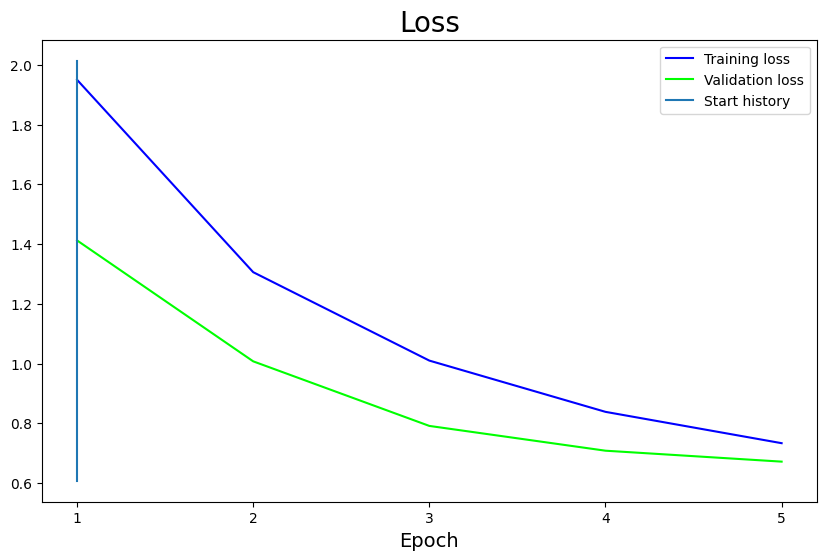

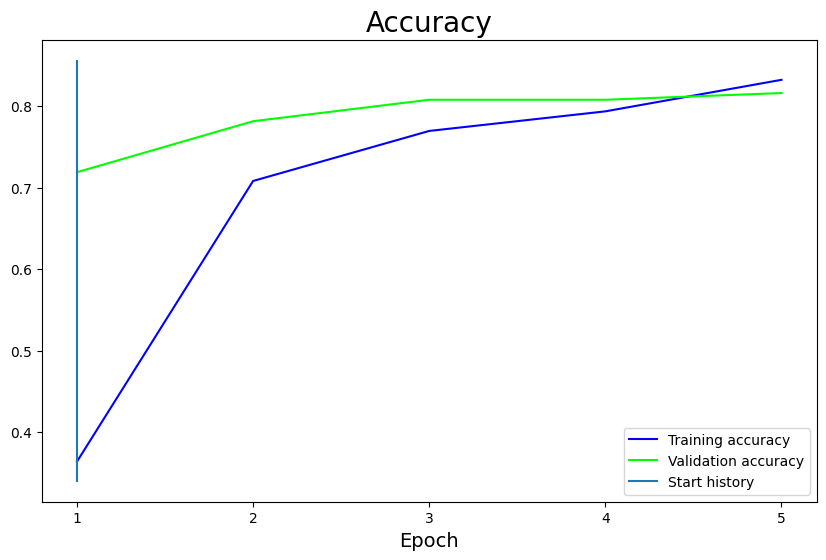

In [43]:
soml.tf.model.plot.plot_history(model_2_history)

### Loading in checkpointed weights

Loading in checkpointed weights returns our model to a specific checkpoint.

In [44]:
soml.tf.model.layer.list_model(model_2, recursive=True, include_trainable=True, include_non_trainable=True)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | True      | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | True      | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | True      | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | True      | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | True      | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [47]:
# Load in saves models weights and evaluate model
soml.tf.model.storage.load_weights(model_2, './checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.67.hdf5')

In [48]:
soml.tf.model.layer.list_model(model_2, recursive=True, include_trainable=True, include_non_trainable=True)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

### Model 3: fine tuning an existing model on 10% of data

**Note**: Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [49]:
# To begin fine tuning, let's start by setting the last 10 layers of our base_model to True.
base_model.trainable = True

# Freeze all layers except for the last 10.
for layer in base_model.layers[:-10]:
    layer.trainable = False

model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                # When fine tuning you typically want to lower learning rate by 10X
                metrics=["accuracy"])

In [50]:
soml.tf.model.layer.list_model(model_2, recursive=True, include_trainable=True, include_non_trainable=True)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [51]:
# Fine tune for another 5 epochs

fine_tune_epochs = initial_epochs + 5

checkpoint_callback = soml.tf.model.callback.model_checkpoint_callback(experiment_name='model_2_fine_tune_10_percent',
                                                                   save_weights_only=True)
tensorboard_callback = soml.tf.model.callback.tensorboard_callback(experiment_name='model_2_fine_tune_10_percent')

model_2_history_fine_tune_last_10 = model_2.fit(train_data_10_percent, steps_per_epoch=len(train_data_10_percent),
                                                epochs=fine_tune_epochs,
                                                initial_epoch=model_2_history.epoch[-1] + 1,
                                                # Start training from previously last epoch (plus 1 otherwise we will do epoch 5 twice)
                                                validation_data=test_data_10_percent,
                                                validation_steps=int(0.25 * len(test_data_10_percent)),
                                                callbacks=[checkpoint_callback, tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_2_fine_tune_10_percent/20230831-225304
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.8307
Epoch 6: saving model to ./checkpoints/model_2_fine_tune_10_percent/model-epoch-06-val_loss-0.54.hdf5
24/24 [==============================] - 59s 2s/step - loss: 0.6204 - accuracy: 0.8307 - val_loss: 0.5434 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8600
Epoch 7: saving model to ./checkpoints/model_2_fine_tune_10_percent/model-epoch-07-val_loss-0.53.hdf5
24/24 [==============================] - 37s 2s/step - loss: 0.5098 - accuracy: 0.8600 - val_loss: 0.5253 - val_accuracy: 0.8289
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8813
Epoch 8: saving model to ./checkpoints/model_2_fine_tune_10_percent/model-epoch-08-val_loss-0.44.hdf5
24/24 [==============================] - 43s 2s/step - loss: 0.4352 -

In [52]:
model_2_evaluate_fine_tune_last_10 = model_2.evaluate(test_data_10_percent)
model_2_evaluate_fine_tune_last_10

79/79 [==============================] - 38s 425ms/step - loss: 0.4275 - accuracy: 0.8596


[0.42746010422706604, 0.8596000075340271]

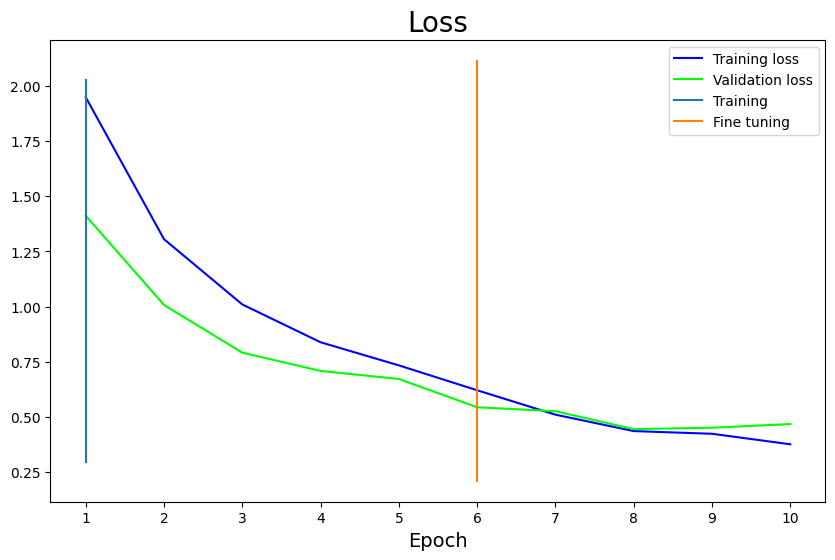

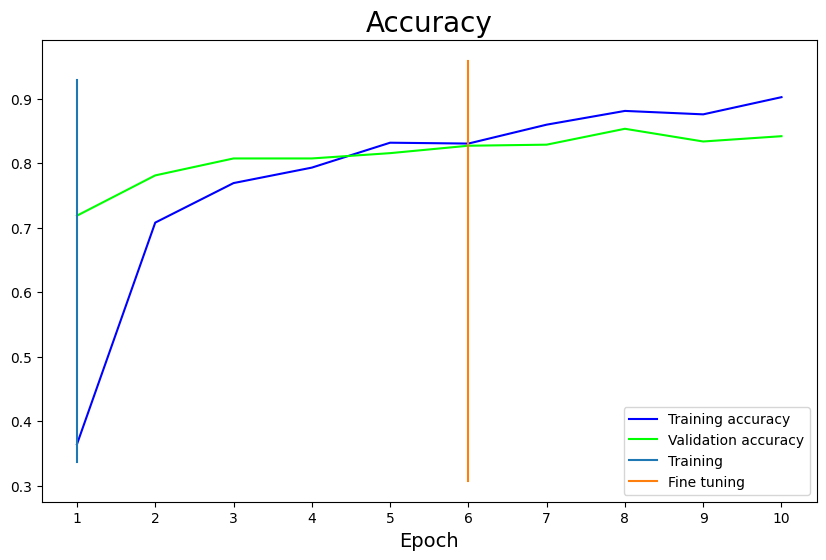

In [53]:
soml.tf.model.plot.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_last_10], ["Training", "Fine tuning"])

## Model 4: Fine-tuning an existing model on all of the data

In [54]:
# Download and unzip 10 food classes of Food101 data with all images
soml.util.io.download_file('https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip',
                   './10_food_classes_all_data.zip')
soml.util.io.extract_zip(filepath='10_food_classes_all_data.zip')
soml.util.io.list_dir_summary('./10_food_classes_all_data')

Download of https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip completed.


In [56]:
# Setup training and test dir
train_dir = './data/10_food_classes_all_data/train'
test_dir = './data/10_food_classes_all_data/test'

In [57]:
IMG_SIZE = (224, 224)

# Setup data input
train_data_all = image_dataset_from_directory(directory=train_dir,
                                              label_mode='categorical',
                                              image_size=IMG_SIZE,
                                              batch_size=32)

test_data_all = image_dataset_from_directory(directory=test_dir,
                                             label_mode='categorical',
                                             image_size=IMG_SIZE,
                                             batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we have been using in previous experiments. Let's verify this...

In [58]:
# Evaluate model_2 (this is the fine tuned on 10 percent of data version
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 25s 309ms/step - loss: 0.4275 - accuracy: 0.8596


[0.42746004462242126, 0.8596000075340271]

In [59]:
model_2_evaluate_fine_tune_last_10

[0.42746010422706604, 0.8596000075340271]

To train a fine tuning model 4 we need to revert model_2 back to its feature extraction version

In [60]:
soml.tf.model.layer.list_model(model_2)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [62]:
# Load weights from checkpoint, that way we can fine tune from the same stage as the 10 percent data model was fine-tuned from.
soml.tf.model.storage.load_weights(model_2, './checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.67.hdf5')

In [63]:
soml.tf.model.layer.list_model(model_2)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [64]:
# Let's evaluate model_2 now
model_2.evaluate(test_data_all)

79/79 [==============================] - 25s 308ms/step - loss: 0.6230 - accuracy: 0.8428


[0.6230241060256958, 0.8428000211715698]

In [65]:
# Check to see if our model has been reverted to feature extracted results.
model_2_evaluation

[0.623024046421051, 0.8428000211715698]

Alright, the previous steps might seem quite confusing but all we have done is:

1. Train a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2), and we saved the models weights
2. Fine-tuned the same model on the same 10 percent of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. We saved the results and training logs each time.
4. Reloaded the model from step 1. To do the same steps as step 2 except this time we're going to use all of the data (model_4)

In [66]:
# Compile

model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [67]:
# Fit

fine_tune_epochs = initial_epochs + 5

tensorboard_callback = soml.tf.model.callback.tensorboard_callback("model_2_fine_tune_100_percent")

model_2_history_fine_tune_all = model_2.fit(train_data_all,
                                            steps_per_epoch=len(train_data_all),
                                            epochs=fine_tune_epochs,
                                            initial_epoch=model_2_history.epoch[-1] + 1,
                                            validation_data=test_data_all,
                                            validation_steps=int(0.25 * len(test_data_all)),
                                            callbacks=[tensorboard_callback])

K.clear_session()

Saving TensorBoard log files to: ./logs/model_2_fine_tune_100_percent/20230831-225940
Epoch 6/10
235/235 [==============================] - 476s 2s/step - loss: 0.8508 - accuracy: 0.7565 - val_loss: 0.6177 - val_accuracy: 0.8553
Epoch 7/10
235/235 [==============================] - 486s 2s/step - loss: 0.8559 - accuracy: 0.7551 - val_loss: 0.6214 - val_accuracy: 0.8536
Epoch 8/10
235/235 [==============================] - 512s 2s/step - loss: 0.8534 - accuracy: 0.7573 - val_loss: 0.6055 - val_accuracy: 0.8618
Epoch 9/10
235/235 [==============================] - 565s 2s/step - loss: 0.8446 - accuracy: 0.7629 - val_loss: 0.6082 - val_accuracy: 0.8503
Epoch 10/10
235/235 [==============================] - 628s 3s/step - loss: 0.8482 - accuracy: 0.7592 - val_loss: 0.6168 - val_accuracy: 0.8503


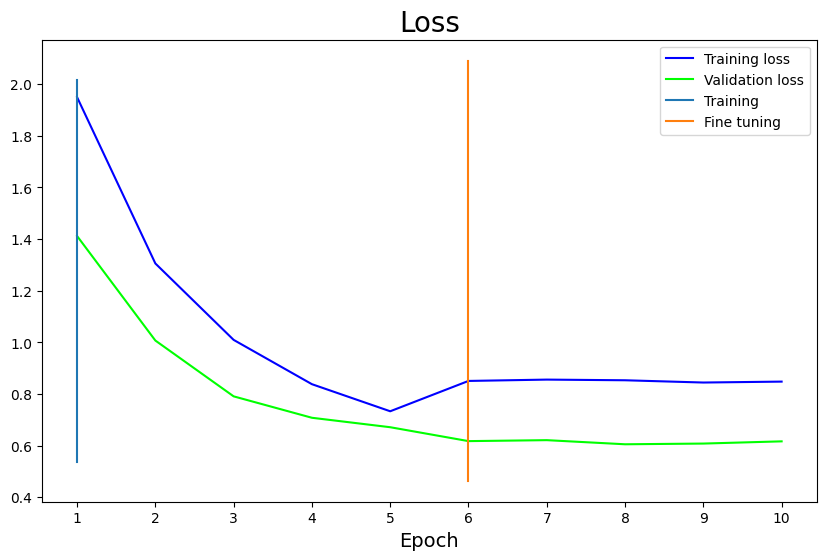

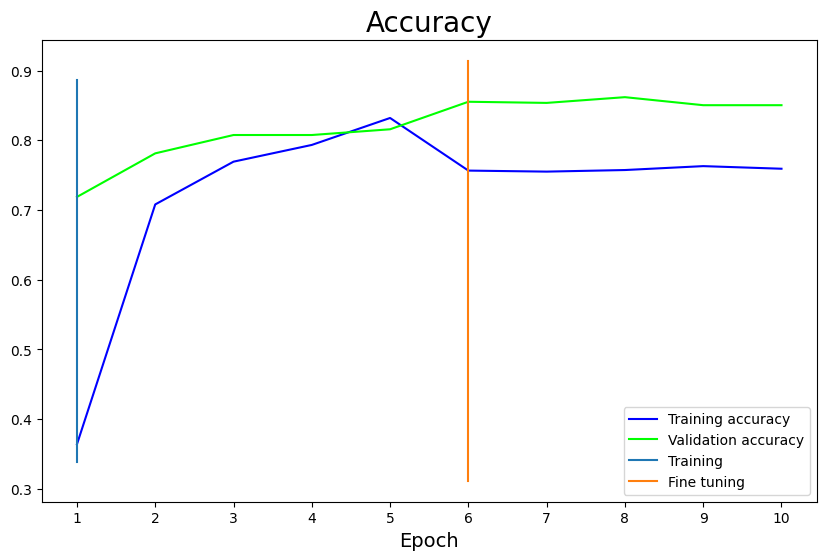

In [68]:
soml.tf.model.plot.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_all], ["Training", "Fine tuning"])

In [69]:
model_2.evaluate(train_data_all)

235/235 [==============================] - 230s 916ms/step - loss: 0.7279 - accuracy: 0.7925


[0.7279228568077087, 0.7925333380699158]

## Try training the last 20 layers af the EfficientNetB0 model and see what the results are.

In [70]:
soml.tf.model.layer.list_model(model_2)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [73]:
# Reload the weights so we can start clean.
soml.tf.model.storage.load_weights(model_2, "./checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.67.hdf5")

In [74]:
soml.tf.model.layer.list_model(model_2)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [75]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [76]:
soml.tf.model.storage.load_weights(model_2, "./checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.67.hdf5")

In [77]:
soml.tf.model.layer.list_model(model_2)

row   | name (type)                                        | dtype   | policy  | trainable | output shape
0     | input_layer               (InputLayer            ) | float32 | float32 | False     | [(None, 224, 224, 3)]   
1     | random_flip               (RandomFlip            ) | float32 | float32 | False     | (None, 224, 224, 3)     
2     | random_height             (RandomHeight          ) | float32 | float32 | False     | (None, None, 224, 3)    
3     | random_width              (RandomWidth           ) | float32 | float32 | False     | (None, None, None, 3)   
4     | random_rotation           (RandomRotation        ) | float32 | float32 | False     | (None, None, None, 3)   
5     | random_zoom               (RandomZoom            ) | float32 | float32 | False     | (None, None, None, 3)   
6     | input_1                   (InputLayer            ) | float32 | float32 | False     | [(None, None, None, 3)] 
7     | rescaling                 (Rescaling             ) | float32

In [ ]:
model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

model_2_history_fine_tune_last_20 = model_2.fit(train_data_all,
                                                steps_per_epoch=len(train_data_all),
                                                initial_epoch=model_2_history.epoch[-1] + 1,
                                                epochs=10,
                                                validation_data=test_data_all,
                                                validation_steps=int(0.25 * len(test_data_all)))

Epoch 6/10
235/235 [==============================] - 1260s 5s/step - loss: 0.6309 - accuracy: 0.7971 - val_loss: 0.2762 - val_accuracy: 0.9079
Epoch 7/10
235/235 [==============================] - 1112s 5s/step - loss: 0.4785 - accuracy: 0.8431 - val_loss: 0.2571 - val_accuracy: 0.9095
Epoch 8/10
235/235 [==============================] - 1091s 5s/step - loss: 0.4165 - accuracy: 0.8680 - val_loss: 0.2555 - val_accuracy: 0.9161
Epoch 9/10
235/235 [==============================] - 1077s 5s/step - loss: 0.3671 - accuracy: 0.8832 - val_loss: 0.2567 - val_accuracy: 0.9194
Epoch 10/10
209/235 [=========================>....] - ETA: 2:13 - loss: 0.3183 - accuracy: 0.8968

In [ ]:
soml.tf.model.plot.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_last_20], ["Training", "Fine tuning"])

In [ ]:
soml.tf.model.storage.load_weights(model_2, "./checkpoints/model_2_aug_10_percent/model-epoch-05-val_loss-0.67.hdf5")

In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

In [ ]:
soml.tf.model.layer.list_model(model_2)

In [ ]:
model_2.compile(loss=categorical_crossentropy,
                optimizer=Adam(learning_rate=0.0001),
                metrics=['accuracy'])

model_2_history_fine_tune_last_30 = model_2.fit(train_data_all,
                                                steps_per_epoch=len(train_data_all),
                                                initial_epoch=model_2_history.epoch[-1] + 1,
                                                epochs=10,
                                                validation_data=test_data_all,
                                                validation_steps=int(0.25 * len(test_data_all)))

In [ ]:
soml.tf.model.plot.plot_consecutive_histories([model_2_history, model_2_history_fine_tune_last_30], ["Training", "Fine tuning"])